Se recomienda ejecutar en Google Colab: https://colab.research.google.com/drive/1PjfsQ6ZBbmubojMUNv8ObDrqLyr5i8WP?usp=sharing

In [ ]:
!pip install torch
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install ipywidgets
!pip install --upgrade huggingface_hub
!pip uninstall transformers -y
!pip install transformers==4.28.0

In [ ]:
import torch
import pandas as pd
import io
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset
import huggingface_hub
import numpy as np
from datasets import load_metric

In [ ]:
# Token de Hugging Face 
token_ = "YOUR_TOKEN_HERE"
os.environ["HUGGINGFACE_CO_TOKEN"] = token_
huggingface_hub.login(token=token_)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


#1. Preprocesamiento

Solo incluye la carga de los datos y su adecuación al modelo (el scraping y el proprocesado complejo puede verlo en los demás ficheros del proyecto)

In [ ]:
from google.colab import files
uploaded = files.upload() # Cargar en Google Colab el dataset

Saving google_reviews_balanced.csv to google_reviews_balanced.csv


In [ ]:
# Lectura como dataset de pandas
Xpandas = pd.read_csv(io.BytesIO(uploaded['google_reviews_balanced.csv']), sep='|')
Xpandas = Xpandas.rename(columns={"review": "text", "class": "label"})
Xpandas

,text,label
0,lifts poorly located in the far corner. kids d...,0
1,i experienced racism! it's so bad.. the cashie...,0
2,very unprofessional staff. manager kitty was s...,0
3,"unprofessional staff, not all of them but the ...",0
4,i bought 3 items at this store at around 8:30p...,0
...,...,...
1429,"staff helpful, clean.",1
1430,cute clothes for a college student like myself,1
1431,nice place. clean,1
1432,good mall but i wish there was more of a varie...,1


In [ ]:
ypandas = Xpandas.pop('label')
ypandas

0       0
1       0
2       0
3       0
4       0
       ..
1429    1
1430    1
1431    1
1432    1
1433    1
Name: label, Length: 1434, dtype: int64

In [ ]:
# Division en train y test
X_train, X_test, y_train, y_test = train_test_split(Xpandas, ypandas, test_size=0.2, random_state=42, stratify=ypandas)

In [ ]:
X_train['label'] = y_train
X_test['label'] = y_test

In [ ]:
# Conversion a estructura dataset
Xd_train = Dataset.from_pandas(X_train, preserve_index=False)
Xd_test = Dataset.from_pandas(X_test, preserve_index=False)

In [ ]:
Xd_train[0]

{'text': 'good variety of clothes at a good price', 'label': 1}

# 2. Entrenamiento del modelo

In [ ]:
# Definir el modelo base DistilBERT
from transformers import AutoModelForSequenceClassification
model_base = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [ ]:
# Cardamos el tokenizador del modelo preentrenado DistilBERT
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Aplicamos el tokenizador al texto de entrada
Xtrain_tokenized = Xd_train.map(lambda review: tokenizer(review["text"], truncation=True), batched=True)
Xtest_tokenized = Xd_test.map(lambda review: tokenizer(review["text"], truncation=True), batched=True)


Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

In [ ]:
# Introducir padding en cada batch para que todas las entradas tengan la misma longitud
from transformers import DataCollatorWithPadding
padding_equalizer = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define the evaluation metrics 
def metricas(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [ ]:
# Parametros de entrenamiento del modelo
from transformers import TrainingArguments, Trainer

trainer = Trainer(
    model=model_base,
    args=TrainingArguments(
      output_dir="dirmodelresults",
      evaluation_strategy="epoch",
      logging_strategy="epoch",
      learning_rate=2e-5,
      num_train_epochs=2,
      weight_decay=0.01
    ),
    train_dataset=Xtrain_tokenized,
    eval_dataset=Xtest_tokenized,
    tokenizer=tokenizer,
    data_collator=padding_equalizer,
    compute_metrics=metricas
)

In [ ]:
# Entrenar
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.016400,0.643989,0.940767,0.943522
2,0.008300,0.420217,0.961672,0.961938


TrainOutput(global_step=288, training_loss=0.01233565972910987, metrics={'train_runtime': 36.0232, 'train_samples_per_second': 63.681, 'train_steps_per_second': 7.995, 'total_flos': 73697926771800.0, 'train_loss': 0.01233565972910987, 'epoch': 2.0})

In [ ]:
# Evaluar
trainer.evaluate()

{'eval_loss': 0.4202165901660919,
 'eval_accuracy': 0.9616724738675958,
 'eval_f1': 0.9619377162629758,
 'eval_runtime': 2.2028,
 'eval_samples_per_second': 130.291,
 'eval_steps_per_second': 16.343,
 'epoch': 2.0}

In [ ]:
# Metricas de rendimiento
history = trainer.state.log_history
history

[{'loss': 0.0164, 'learning_rate': 1e-05, 'epoch': 1.0, 'step': 144},
 {'eval_loss': 0.643988847732544,
  'eval_accuracy': 0.9407665505226481,
  'eval_f1': 0.9435215946843855,
  'eval_runtime': 2.2302,
  'eval_samples_per_second': 128.687,
  'eval_steps_per_second': 16.142,
  'epoch': 1.0,
  'step': 144},
 {'loss': 0.0083, 'learning_rate': 0.0, 'epoch': 2.0, 'step': 288},
 {'eval_loss': 0.4202165901660919,
  'eval_accuracy': 0.9616724738675958,
  'eval_f1': 0.9619377162629758,
  'eval_runtime': 2.6158,
  'eval_samples_per_second': 109.72,
  'eval_steps_per_second': 13.763,
  'epoch': 2.0,
  'step': 288},
 {'train_runtime': 36.0232,
  'train_samples_per_second': 63.681,
  'train_steps_per_second': 7.995,
  'total_flos': 73697926771800.0,
  'train_loss': 0.01233565972910987,
  'epoch': 2.0,
  'step': 288},
 {'eval_loss': 0.4202165901660919,
  'eval_accuracy': 0.9616724738675958,
  'eval_f1': 0.9619377162629758,
  'eval_runtime': 2.2028,
  'eval_samples_per_second': 130.291,
  'eval_steps

# 3. Guardar modelo

In [ ]:
trainer.push_to_hub("finetuning-sentiment-model")

# 4. Representar el modelo

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
metricas_epocas = pd.DataFrame({'eval_acc': [history[1]["eval_accuracy"],  history[3]["eval_accuracy"]],
              'eval_loss': [history[1]["eval_loss"],  history[3]["eval_loss"]],
              }, index=[1,2])
metricas_epocas

,eval_acc,eval_loss
1,0.940767,0.643989
2,0.961672,0.420217


Text(0.5, 1.0, 'Accuracy and loss')

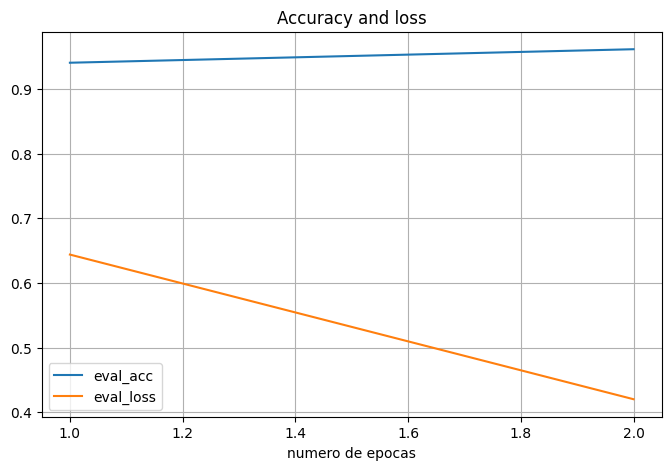

In [ ]:
metricas_epocas.plot(figsize=(8,5))

plt.grid(True)
plt.xlabel('numero de epocas')
plt.title('Accuracy and loss')  # Solo tenemos dos epocas, que es mas que suficiente, asi que 
                                # el grafico es una recta con pendiente positiva para el accuracy y con pendiente negativa para el loss
